# **Ingef ML Task**

by Diego Huerfano

Import first all the necessary modules:

In [30]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report

import seaborn as sns
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, InputLayer
from tensorflow.keras.regularizers import L2 
from tensorflow.keras.optimizers import SGD

import statsmodels.api as sm

sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

The data provides simulated sample data of patients stays in hospitals for the years 2017 and 2018. It includes 100000 records and 12 fields.

In [16]:
data = pd.read_csv("../input/ingef-dataset/simulierte_falldaten.csv", decimal=",", delimiter=";")
data = data.dropna()
print(data.columns)
print(data.iloc[:5])

Index(['Fallnummer', 'Krankenhaus_IK', 'Rechnungsdatum', 'Rechnungsbetrag',
       'DRG', 'Aufnahmejahr', 'Aufnahmedatum', 'Entlassdatum', 'Verweildauer',
       'Hauptdiagnose', 'Aufnahmediagnose', 'Pruefungsergebnis'],
      dtype='object')
                                 Fallnummer  Krankenhaus_IK Rechnungsdatum  \
0  2792729755436986343261121843235743838568            1605     2018-04-16   
1  1460552357600126634026229874994783383147            1520     2018-02-21   
2  3047887335342996907787409480022726989017            1967     2017-07-24   
3  8876397937793024850982709322013175445188            1804     2018-02-11   
4  6928430152868057011091049996703290177724            1476     2017-03-19   

   Rechnungsbetrag   DRG  Aufnahmejahr Aufnahmedatum Entlassdatum  \
0           1735.2  H41D          2018    2018-03-25   2018-03-31   
1           3414.4  T01D          2017    2017-11-05   2017-11-17   
2           1644.0  O01H          2017    2017-05-31   2017-06-06   
3           

# **Data Description**

1.   Fallnummer := ID Variable zur Identifikation eines Krankenhausfalls
2.   Krankenhaus_IK := 4 - stelliges Institutionskennzeichen für einzelne Krankenhäuser
3.   Rechnungsdatum := Datum des Eingangs der Rechnung
4.   Rechnungsbetrag := Betrag der Rechnung in Euro
5.   DRG := Diagnosis Related Group (auch: Fallpauschale). Eine Beschreibung der einzelnen DRGs finden Sie hier: https://www.g-drg.de/content/download/7900/58890/version/2/file/Fallpauschalenkatalog+2019_180928.pdf 
6.   Aufnahmejahr := Jahr des Aufnahmedatums. Werte: 2017 und 2018 
7.   Aufnahmedatum := Datum der Aufnahme im Krankenhaus
8.   Entlassdatum := Datum der Entlassung aus dem Krankenhaus
9.   Verweildauer := Anzahl der Tage des Krankenhausaufenthaltes
10.   Hauptdiagnose := Hauptdiagnose des Krankenhausfalles
11.  Aufnahmediagnose := Aufnahmediagnose des Krankenhausfalles (Diagnose, die zum Beginn des Krankenhausaufenthaltes vergeben wird. Theoretisch kann es mehrere geben, in diesen simulierten Daten aber nur eine.)
12.  Pruefungsergebnis := Ergebnis einer Überprüfung der Abrechnung des Krankenhausfalles. Ziel ist die Prädiktion dieser Variable. Die Variable hat die beiden Ausprägungen "erfolgreich" und "erfolglos". Erfolgreich sind die Prüfungen, die zu einer Ersparnis für die Krankenkasse führen. Die Ersparnis wird in dieser Aufgabe aber nicht betrachtet.

# **Prediction variable (desired target):**

In [17]:
print(data['Pruefungsergebnis'].unique())

['erfolgreich' 'erfolglos']


**Partioning of Data According to the Task Description**

We divide the input data into the training data and test data. 

The training data consists of records whose field *Aufnahmejahr* is 2017.

The test data consists f records whose field *Aufnahmejahr* is 2018.

In [40]:
data_train = data[data['Aufnahmejahr']==2017].drop(columns=['Aufnahmejahr', 'Fallnummer', 'Aufnahmedatum', 'Entlassdatum'])
data_test = data[data['Aufnahmejahr']==2018].drop(columns=['Aufnahmejahr', 'Fallnummer', 'Aufnahmedatum', 'Entlassdatum'])

print("Traininig Data")
print(data_train.iloc[:5])
print("Testing Data")
print(data_test.iloc[:5])

Traininig Data
   Krankenhaus_IK Rechnungsdatum  Rechnungsbetrag   DRG  Verweildauer  \
1            1520     2018-02-21           3414.4  T01D            12   
2            1967     2017-07-24           1644.0  O01H             6   
4            1476     2017-03-19           1281.2  L63F             7   
6            1479     2017-09-21           2401.2  D25D             7   
7            1247     2017-08-29           3509.6  I08F            10   

  Hauptdiagnose Aufnahmediagnose Pruefungsergebnis  
1         G81.1            F10.0       erfolgreich  
2         J45.8            J38.5       erfolgreich  
4         N39.0            N39.0         erfolglos  
6         H65.0            T78.4       erfolgreich  
7         C34.9           E11.73       erfolgreich  
Testing Data
    Krankenhaus_IK Rechnungsdatum  Rechnungsbetrag   DRG  Verweildauer  \
0             1605     2018-04-16           1735.2  H41D             6   
3             1804     2018-02-11            453.2  P67E           

# **Exploration and Preparation of Data**

We notice that the target classes are not super unbalanced since the ratio of succesful and unsuccesful instances is 62:37

erfolgreich    31134
erfolglos      18866
Name: Pruefungsergebnis, dtype: int64


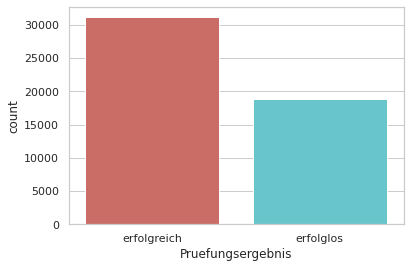

<Figure size 432x288 with 0 Axes>

In [19]:
print(data_train['Pruefungsergebnis'].value_counts())
sns.countplot(x='Pruefungsergebnis', data=data_train, palette='hls')
plt.show()
plt.savefig('count_plot_1')

We also observe that the average of *Rechnungsbetrag* for the unsuccesful instances is larger than the respective one for the succesful instances. The same observation also holds for the average of *Verweildauer*.

In [20]:
data_train[['Rechnungsbetrag', 'Verweildauer', 'Pruefungsergebnis']].groupby('Pruefungsergebnis').mean()

,Rechnungsbetrag,Verweildauer
Pruefungsergebnis,,
erfolglos,2745.543202,7.889166
erfolgreich,1932.136967,6.112546


In [28]:
print("Count DRG cats:", len(data_train['DRG'].unique()))
print("Count Krankenhaus_IK cats:", len(data_train['Krankenhaus_IK'].unique()))
print("Count Hauptdiagnose cats:", len(data_train['Hauptdiagnose'].unique()))
print("Count Aufnahmediagnose cats", len(data_train['Aufnahmediagnose'].unique()))

Count DRG cats: 1167
Count Krankenhaus_IK cats: 1001
Count Hauptdiagnose cats: 2248
Count Aufnahmediagnose cats 2258


**Select and Create Dummy Variables**

Now we transfrom the categorical variables *DRG*, *Krankenhaus_IK*, *Hauptdiagnose*, *Aufnahmediagnose* using one-hot encoding. Furthermore, we dismiss the variables *Aufnahmedatum* and *Entlassdatum* owing to two reasons. One the one hand, the variable *Verweildauer* gives us the total duration of hospitalization in days and on the other hand, we can also assume that the conditions/variables involved in our data set stay unchanged along a given year.

In [21]:
data_cat = data[['DRG', 'Krankenhaus_IK', 'Hauptdiagnose', 'Aufnahmediagnose']]

onehot_encoder = OneHotEncoder(sparse=True, handle_unknown='ignore')
label_encoder = preprocessing.LabelEncoder()
onehot_encoded = onehot_encoder.fit_transform(data_cat)
print(label_encoder.classes_)


# merge two dataframes (SQL style) to create the final training dataframe: 
#    1. First Dataframe: training data with the features 'Rechnungsbetrag' and 'Verweildauer'
#    2. Second Dataframe: one hot encoding of all the categorical varibles on the whole data set.
X = pd.merge(data_train[['Rechnungsbetrag', 'Verweildauer']], pd.DataFrame.sparse.from_spmatrix(onehot_encoded), how='inner', left_index=True, right_index=True)
Y = label_encoder.fit_transform(data_train['Pruefungsergebnis'])

# data normalization:
X.Rechnungsbetrag=(X.Rechnungsbetrag-X.Rechnungsbetrag.mean())/X.Rechnungsbetrag.std()
X.Verweildauer =(X.Verweildauer-X.Verweildauer.mean())/X.Verweildauer.std()
print("Training Data:")
print(X[:5])
print(Y[:5])


# merge two dataframes (SQL style) to create the final testing dataframe: 
#    1. First Dataframe: testing data with the features 'Rechnungsbetrag' and 'Verweildauer'
#    2. Second Dataframe: one hot encoding of all the categorical varibles on the whole data set.
X_test = pd.merge(data_test[['Rechnungsbetrag', 'Verweildauer']], pd.DataFrame.sparse.from_spmatrix(onehot_encoded), how='inner', left_index=True, right_index=True)
Y_test = label_encoder.fit_transform(data_test['Pruefungsergebnis'])

# data normalization:
X_test.Rechnungsbetrag=(X_test.Rechnungsbetrag-X_test.Rechnungsbetrag.mean())/X_test.Rechnungsbetrag.std()
X_test.Verweildauer =(X_test.Verweildauer-X_test.Verweildauer.mean())/X_test.Verweildauer.std()
print("Testing Data:")
print(X_test[:5])
print(Y_test[:5])

['erfolglos' 'erfolgreich']
Train Data:
   Rechnungsbetrag  Verweildauer    0    1    2    3    4    5    6    7  ...  \
1         0.448493      0.993605  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2        -0.227062     -0.149105  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
4        -0.365500      0.041347  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
6         0.061873      0.041347  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
7         0.484820      0.612702  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   

   7242  7243  7244  7245  7246  7247  7248  7249  7250  7251  
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
6   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
7   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 7254 columns]
[1 1 0 1 1]
Test Data:
    Rechnungsbetrag  Verweildauer    0   

# **Logistic Regresion Model**

Since we have now 7254 features, it is sensible to reduce model complexity by dropping variables that are not good estimators of the prediction variable. We can achieve that by applying the *lasso* variant of the logistic regresion allowing us to perform variable selection and regularization. This process allows us to automatically identify from the data the relevant variables to the outcome which is very useful for this task due to the large number of categories of the variables *DRG*, *Hauptdiagnose* and *Aufnahmediagnose* (the three of them important for the model from a nonexpert point of view).  

We perfrom grid search for the paramter C (inverse of regularization strength) of the algorithm and at the end we instantiate out model with the best one.

In [22]:
parameters = {'C':[0.01, 0.1, 0.2, 0.3, 0.5, 1]}
clf = GridSearchCV(estimator=LogisticRegression(penalty='l1', solver='liblinear', max_iter=100, fit_intercept=False), param_grid=parameters, n_jobs=1)
clf.fit(X, Y)
print(clf.best_params_, clf.best_score_)

# instantiate model with best parameter:
model = LogisticRegression(penalty='l1', solver='liblinear', C=clf.best_params_['C'], max_iter=100, fit_intercept=False).fit(X, Y)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:509: UserWarning: pandas.DataFrame with sparse co

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:509: UserWarning: pandas.DataFrame with sparse co

{'C': 0.3} 0.70008


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


# **Second classifier**

Our sescond binary classifier will be a deep neural network. Before we train our network, we apply the RFE (Recursive Feature Elimination) algorithm with a Decision Tree Classifier in order to select the relevant features in order to reduce model complexity. In the end we will have 512 features to work with.

Note that the first two features, i.e., *Rechnungsbetrag* and *Verweildauer*, are kept by the algorithm which confirms the intuition that these features must be good predictors of the outcome variable.

In [23]:
n_features_to_select=512
rfe = RFE(estimator=DecisionTreeClassifier(max_depth=50), n_features_to_select=n_features_to_select, step=100, verbose=0)
rfe = rfe.fit(X, Y)
print(rfe.support_[0:10])

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


[ True  True False False False  True False False False False]


The neural network consits of 5 layers, activated by the Relu function and the last one activated by the sigmoid function. We also use weight decay and dropout after each hidden layer to reduce overfitting.

To train the network we apply SGD algorithm and binary cross entropy as loss function that is suitable for binary classification tasks.

In [41]:
lambda_reg = 0.001
learning_rate=0.25
batch_size=64
epochs=25

nn_model = Sequential()
nn_model.add(InputLayer(input_shape=(n_features_to_select, )))
nn_model.add(Dense(1024, activation='relu', kernel_regularizer=L2(lambda_reg), bias_regularizer=L2(lambda_reg)))
nn_model.add(Dropout(rate=0.3))
nn_model.add(Dense(1024, activation='relu', kernel_regularizer=L2(lambda_reg), bias_regularizer=L2(lambda_reg)))
nn_model.add(Dropout(rate=0.35))
nn_model.add(Dense(256, activation='relu', kernel_regularizer=L2(lambda_reg), bias_regularizer=L2(lambda_reg)))
nn_model.add(Dropout(rate=0.4))
nn_model.add(Dense(128, activation='relu', kernel_regularizer=L2(lambda_reg), bias_regularizer=L2(lambda_reg)))
nn_model.add(Dropout(rate=0.4))
nn_model.add(Dense(1, activation='sigmoid', kernel_regularizer=L2(lambda_reg), bias_regularizer=L2(lambda_reg)))

nn_model.summary()


# transform the train and test data into the right format and select the desired features masked by rfe.support_
X_nn_train = np.asarray(X.loc[:, rfe.support_]).astype(np.float32)
Y_nn_train = np.asarray(Y).astype(np.float32)

X_nn_test = np.asarray(X_test.loc[:, rfe.support_]).astype(np.float32)
Y_nn_test = np.asarray(Y_test).astype(np.float32)


print(X_nn_train.shape)
print(X_nn_test.shape)

nn_model.compile(optimizer=SGD(learning_rate=learning_rate), loss=tf.keras.losses.BinaryCrossentropy())
history = nn_model.fit(X_nn_train, Y_nn_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=1)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dropout_12 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_13 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)               262400    
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)              

# **Comparison of Models**

**1) ROC Curves**

*Comparison of AUCs in Absolute Terms:* the logistic regression classifier has an AUC of 0.64, and the neural network classifier has an AUC of 0.66, so the latter is clearly better with this criterium.

*Thereshold selection:* Furthermore, depending on the problem context for which we would like to apply these models, we might be interested to select a thereshold for the classifiers such that the FPR lies aprox. between 0.4 and 0.5. Within these range we observe in the Figure that the neural network also performs better. However, the opposite holds for the range (0, 0.3) aprox.

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


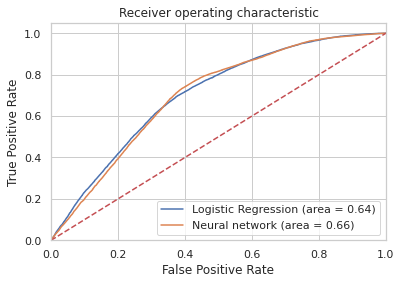

<Figure size 432x288 with 0 Axes>

In [42]:
logit_roc_auc = roc_auc_score(Y_test, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(Y_test, model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)

preds = nn_model.predict(X_nn_test)
logit_roc_auc = roc_auc_score(Y_nn_test, [round(x[0]) for x in preds])
fpr, tpr, thresholds = roc_curve(Y_nn_test, preds)
plt.plot(fpr, tpr, label='Neural network (area = %0.2f)' % logit_roc_auc)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()
plt.savefig('ROC curves')

**2) Precision, recall, F-measure and Support**

In [45]:
print(classification_report(Y_test, model.predict(X_test)))

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


              precision    recall  f1-score   support

           0       0.76      0.45      0.57     26786
           1       0.57      0.84      0.68     23214

    accuracy                           0.63     50000
   macro avg       0.67      0.64      0.62     50000
weighted avg       0.67      0.63      0.62     50000



In [46]:
print(classification_report(Y_nn_test, [round(x[0]) for x in preds]))

              precision    recall  f1-score   support

         0.0       0.76      0.50      0.60     26786
         1.0       0.59      0.82      0.68     23214

    accuracy                           0.65     50000
   macro avg       0.67      0.66      0.64     50000
weighted avg       0.68      0.65      0.64     50000



Finally, using F_1 score to meassure the models performance, we also note that the neural network performs a bit better with an accuracy of 0.65 than the logistic regression model with an accuracy of 0.63.

# **Conclusion**

From the experiments it can be seen that the neural network model performs slightly better that the logistic regression model according to the different criteria that we chose to compare them. However, due to the similarity of measures in the different test it would be necessary to carry out a test to verify whether the differnece is statistically significant.